# Mask R-CNN is an object detection model based on deep convolutional neural networks (CNN).The model can return both the bounding box and a mask for each detected object in an image.

In [ ]:
# Mount google drive
from google.colab import drive  
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AIML/capstone/kaggle"

In [ ]:
import os
orig_dir = os.getcwd()
os.chdir('/content/drive/MyDrive/AIML/capstone/kaggle')
#do stuff


In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 4.1 MB/s 


In [ ]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
DATA_DIR = '/content/drive/MyDrive/AIML/capstone/kaggle/'

# Directory to save logs and trained model
ROOT_DIR = '/content/drive/MyDrive/AIML/capstone/kaggle/working'



In [ ]:
!pip install --no-deps tensorflow==1.15.3
!pip install --no-deps keras==2.2.5
!pip install tensorboard==1.15.0
!pip install tensorflow.estimator==1.15.1
!pip install tensorflow-gpu==1.15.0


In [ ]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding licens

In [ ]:
!pip install Keras-Applications==1.0.8

In [ ]:
!pip install h5py==2.10.0

In [ ]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

# Some setup functions and classes for Mask-RCNN
- dicom_fps is a list of the dicom image path and filenames
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [ ]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [ ]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
   # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32

    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
     #The reference (e.g. path or link) by which the image is retrieved.          
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    #Reads and returns an image.
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

   #Loads the masks for the objects in an image.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# Examine the annotation data, parse the dataset, and view dicom fields

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [ ]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.15558.1517874387.373810
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.15558.1517874387.373810
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

# Split the data into training and validation datasets

Note: We have only used only a portion of the images for demonstration purposes. See comments below.

To use all the images do: image_fps_list = list(image_fps)
Or change the number of images from 100 to a custom number

In [ ]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:1000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

900 100


# Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height

In [ ]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    57b7c911-a726-457c-b588-0a1ffdf0ad5f
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 7524, dtype: object]

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# Display a random image with bounding boxes

(1024, 1024, 3)
/content/drive/MyDrive/AIML/capstone/kaggle/stage_2_train_images/3be59bb1-6183-4c8d-9ac8-4591b6ab90d0.dcm
[1 1]


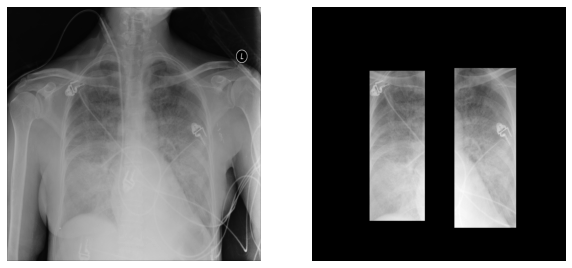

In [ ]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [ ]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

# Image Augmentation. Try finetuning some variables to custom values

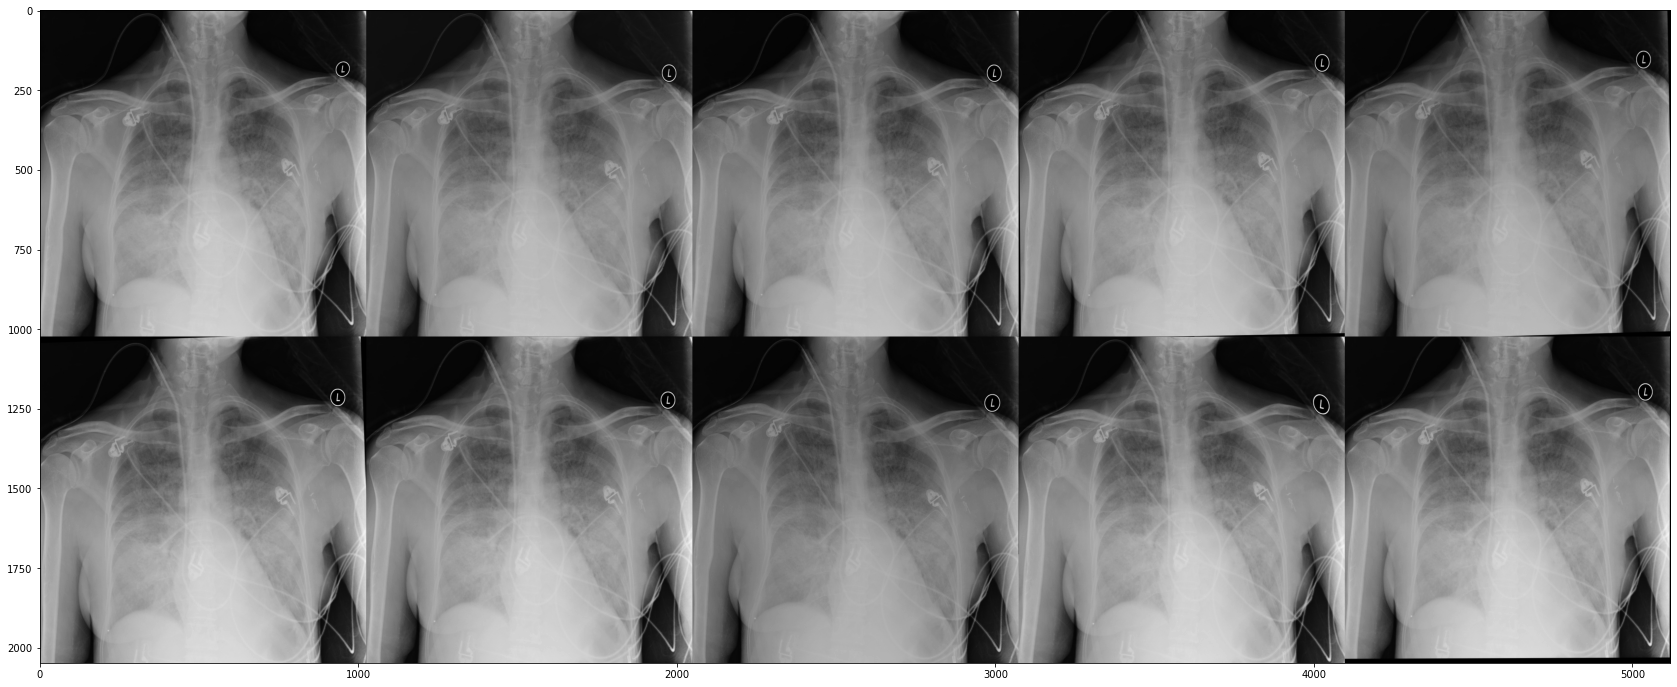

In [ ]:



augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

# Now it's time to train the model. Note that training even a basic model can take a few hours.
Note: the following model is for demonstration purpose only. We have limited the training to 16 epochs, and have set nominal values for the Detector Configuration to reduce run-time.

- dataset_train and dataset_val are derived from DetectorDataset
- DetectorDataset loads images from image filenames and masks from the annotation data
- model is Mask-RCNN

In [ ]:
NUM_EPOCHS = 16

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220316T0846/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220301T0831
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220301T0850
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220301T0901
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220301T0948
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220302T0741
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220302T0914
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220302T0936
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220302T1022
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220302T1032
No weight files in /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220303T0732
No weight files in /content/drive/MyDrive/AIML/capstone/kagg

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)
model_path = "/content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220316T0846/mask_rcnn_pneumonia_0016.h5"
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/AIML/capstone/kaggle/working/pneumonia20220316T0846/mask_rcnn_pneumonia_0016.h5
Re-starting from epoch 16


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.785107,0.309759,1.027207,0.255521,0.631850,0.560753,3.709759,0.835436,1.303811,0.261722,0.678563,0.630210
2,2.581876,0.329296,1.037763,0.154440,0.507830,0.552529,2.643545,0.343727,0.941584,0.250639,0.548251,0.559327
3,2.467058,0.291885,0.898004,0.177690,0.548468,0.550995,2.500657,0.318917,0.881542,0.238371,0.523755,0.538054
4,2.350571,0.300205,0.893559,0.193741,0.457209,0.505839,2.404286,0.292260,0.866617,0.236552,0.489966,0.518873
5,2.297774,0.281064,0.817162,0.222201,0.482674,0.494655,2.276189,0.285134,0.798577,0.222249,0.466606,0.503606
6,2.249526,0.273171,0.782419,0.199778,0.522918,0.471223,2.157872,0.272745,0.741663,0.215961,0.438140,0.489346
7,2.167954,0.237506,0.763439,0.194524,0.503565,0.468903,2.015646,0.235040,0.688119,0.195120,0.425827,0.471522
8,2.255899,0.267769,0.747862,0.243509,0.534641,0.462100,1.984579,0.243069,0.673377,0.196718,0.405626,0.465771
9,2.179340,0.272185,0.757293,0.190113,0.509845,0.449888,1.952339,0.242052,0.651920,0.204560,0.394231,0.459559
10,2.091784,0.244334,0.719994,0.211797,0.484233,0.431409,1.882829,0.219453,0.641652,0.191056,0.380926,0.449725


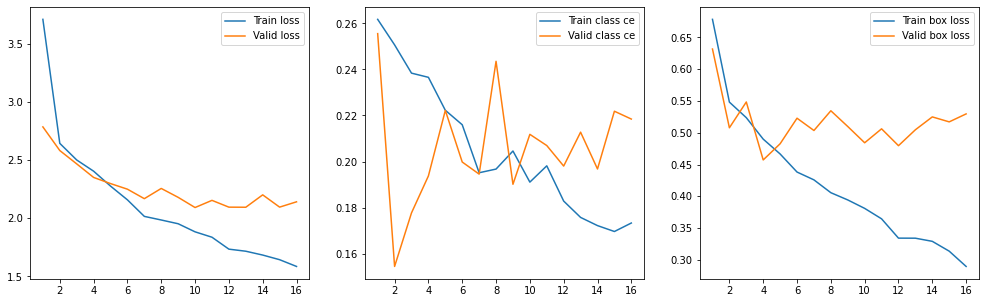

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):

    AR = []
    for iou_threshold in list_iou_thresholds:

        try:
            recall, _ = compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

            AR.append(recall)

        except:
          AR.append(0.0)
          pass

    AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
    return AUC

In [ ]:
class PredictionConfig(Config):
	NAME = "acerola_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1


In [ ]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap, compute_recall
from numpy import expand_dims
from mrcnn import utils
from numpy import mean
def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):

  if list_iou_thresholds is None: list_iou_thresholds = np.arange(0.3, 1.01,0.1)

  APs = []
  ARs = []
  F1_scores = list();
  for image_id in dataset.image_ids:
		
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		
    scaled_image = mold_image(image, cfg)
		
    sample = expand_dims(scaled_image, 0)
		
    yhat = model.detect(sample, verbose=0)
		
    r = yhat[0]
		
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5)
		
    AR = compute_ar(r['rois'], gt_bbox, list_iou_thresholds)
    ARs.append(AR)
    F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))
    APs.append(AP)

  mAP = max(APs)
  mAR = max(ARs)
  

  return mAP, mAR, F1_scores

In [ ]:
from numpy.ma.core import argmax
dataset = dataset_val
mAP,mAR,F1_scores = evaluate_model(dataset, model, inference_config)
print("mAR: %.3f" % mAR)
print("first way calculate f1-score: ", F1_scores)



mAR: 0.900
first way calculate f1-score:  [nan, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.6666666666666666, nan, nan, 0.0, 0.6666666666666666, nan, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.42857142857142855, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, nan, 0.375, nan, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.5555555555555556, 0.0, 0.0, 0.6818181818181818, nan, 0.0, nan, nan]


# How does the predicted box compared to the expected value? Let's use the validation dataset to check.
Note that we trained only 16 epochs for demonstration purposes ONLY. You might be able to improve performance running more epochs.


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



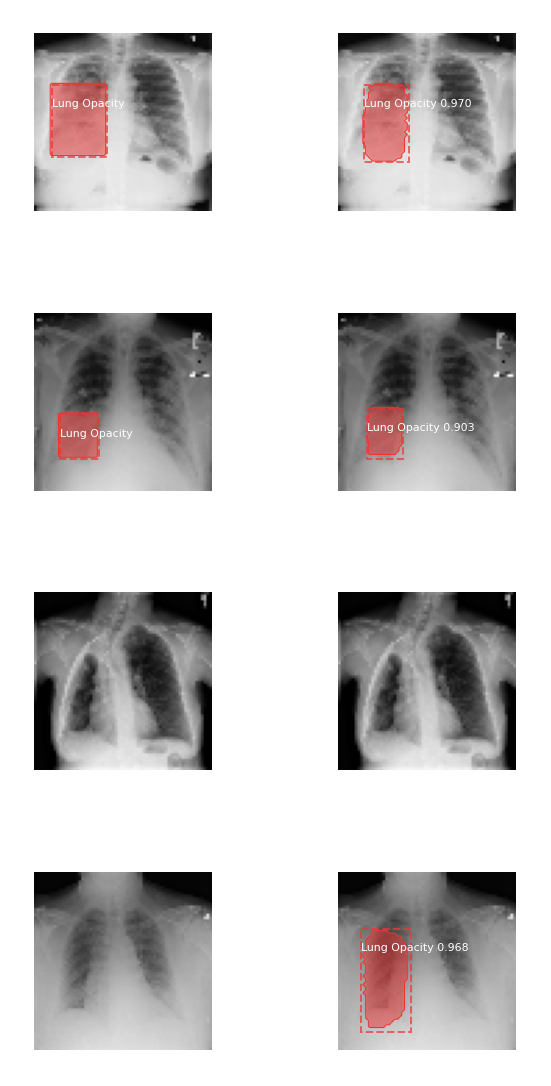

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    #mrcnn.visualize.display_instances() function is used for displaying the detection boxes, masks, class names, and scores.
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    
    

In [ ]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

# Final steps - Create the submission file

In [ ]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='maskrcnn_submission.csv', min_conf=0.98): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [ ]:
# predict only the first 50 entries
sample_submission_fp = 'maskrcnn_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)

100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


In [ ]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)

,id,pred_string
0,003d17f0-bd8a-485c-bc8b-daec33f53efa,0.99 223 336 197 228
1,24e408ee-ffab-4bc2-b82e-356d87e2b20d,NaN
2,2badcdd6-4733-47ae-bdfc-412bb853e9a1,NaN
3,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.99 210 339 218 382
4,30e2f3c5-3315-46cf-ac57-b1ad8bb32f9a,NaN
5,19dbd4e3-db2f-4b33-b3db-96a3d993e5f9,NaN
6,2a731e8d-4b28-46ec-b22d-01cbcbf67d12,0.99 188 523 213 207
7,252841f2-7c5e-4554-8181-0c651a885d41,NaN
8,1d5d0cf0-d3e3-4919-af0d-2ee56f31e0e0,NaN
9,0d5b9d41-4d7b-4539-8f63-0bcbb56d3d59,NaN


220636b9-b401-438a-a894-529918d12af9
[12 13 48 28]
x 208 y 192 h 240 w 576
[14 38 50 53]
x 608 y 224 h 240 w 576
c129ed85-8cdc-4505-972e-661a36fd9234
[10  9 46 25]
x 144 y 160 h 256 w 576
28531cef-f479-419a-a6de-82e45916534e
[28 12 50 28]
x 192 y 448 h 256 w 352
27eef917-370c-41a9-b97a-07fd4cf3fb33
[10 38 53 56]
x 608 y 160 h 288 w 688
[14 17 49 35]
x 272 y 224 h 288 w 560


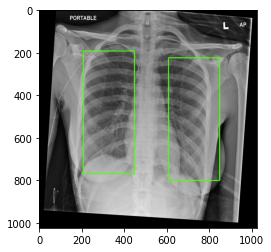

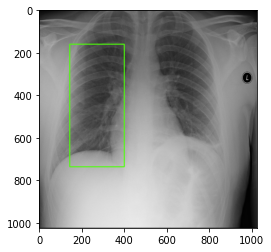

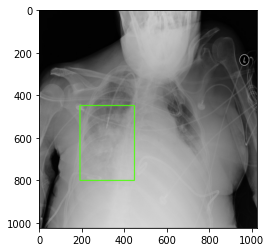

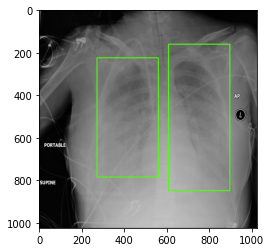

In [ ]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()